# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project: Finding Donors for *CharityML*

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Please specify WHICH VERSION OF PYTHON you are using when submitting this notebook. Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

**Hint:** You may need to look at the table above to understand how the `'income'` entries are formatted. 

In [2]:
# TODO: Total number of records
n_records = data.shape[0]

# TODO: Number of records where individual's income is more than $50,000
n_greater_50k = sum(data['income'] == '>50K')

# TODO: Number of records where individual's income is at most $50,000
n_at_most_50k = sum(data['income'] == '<=50K')

# TODO: Percentage of individuals whose income is more than $50,000
greater_percent = n_greater_50k/float(n_records)*100

# Print the results
print "Total number of records: {}".format(n_records)
print "Individuals making more than $50,000: {}".format(n_greater_50k)
print "Individuals making at most $50,000: {}".format(n_at_most_50k)
print "Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent)

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

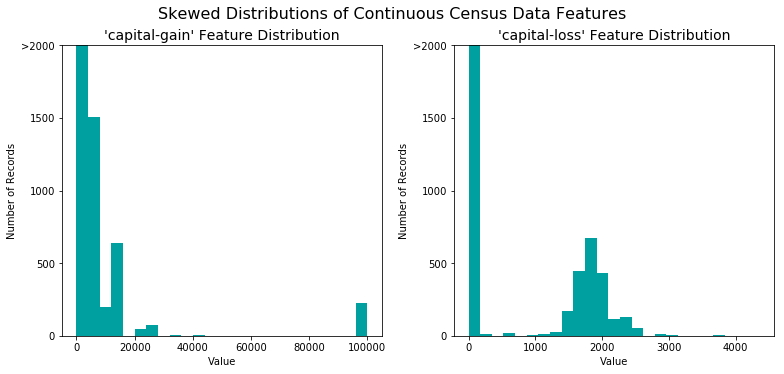

In [3]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

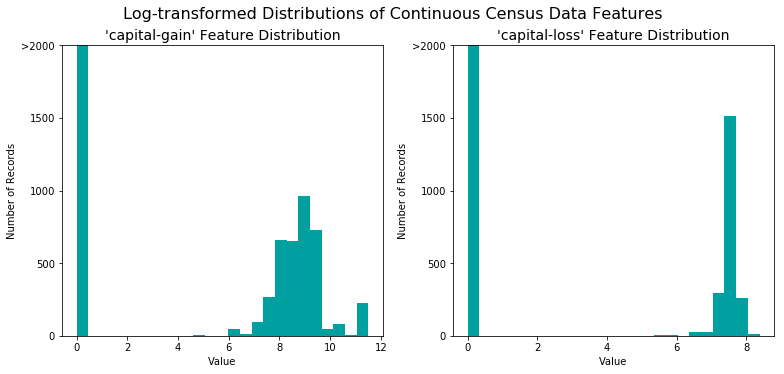

In [4]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_raw[skewed] = data[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_raw, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [5]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
features_raw[numerical] = scaler.fit_transform(data[numerical])

# Show an example of a record with scaling applied
display(features_raw.head(n = 1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.30137,State-gov,Bachelors,0.8,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_raw'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [6]:
# TODO: One-hot encode the 'features_raw' data using pandas.get_dummies()
features = pd.get_dummies(features_raw)

# TODO: Encode the 'income_raw' data to numerical values
income = income_raw.map({'>50K':1, '<=50K':0})

# Print the number of features after one-hot encoding
encoded = list(features.columns)
print "{} total features after one-hot encoding.".format(len(encoded))

# Uncomment the following line to see the encoded feature names
print encoded

103 total features after one-hot encoding.
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_level_ 10th', 'education_level_ 11th', 'education_level_ 12th', 'education_level_ 1st-4th', 'education_level_ 5th-6th', 'education_level_ 7th-8th', 'education_level_ 9th', 'education_level_ Assoc-acdm', 'education_level_ Assoc-voc', 'education_level_ Bachelors', 'education_level_ Doctorate', 'education_level_ HS-grad', 'education_level_ Masters', 'education_level_ Preschool', 'education_level_ Prof-school', 'education_level_ Some-college', 'marital-status_ Divorced', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowed', 'occupation_ A

### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [7]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, income, test_size = 0.2, random_state = 0)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 

### Question 1 - Naive Predictor Performace
*If we chose a model that always predicted an individual made more than \$50,000, what would that model's accuracy and F-score be on this dataset?*  
**Note:** You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

In [8]:
# TODO: Calculate accuracy
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
y_pred = np.zeros(len(y_test))
accuracy = accuracy_score(y_test, y_pred)

# TODO: Calculate F-score using the formula above for beta = 0.5
beta = 0.5
#precision = float(precision_score(y_test, y_pred)) #when we predict >50, how often are we right?
#recall = recall_score(y_test, y_pred) #when >50K is true, how often do we predict correctly
cf = confusion_matrix(y_test,y_pred)
tn = cf[0,0]; tp = cf[1,0]; fn=cf[1,0]; fp= cf[0,1]
precision = tp/(tp+fp)
recall = tp/(tp+fn)

fscore = (1+beta**2)*(precision*recall/(beta**2*precision+recall))

# Print the results 
print "Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore)

Naive Predictor: [Accuracy score: 0.7562, F-score: 0.0000]


###  Supervised Learning Models
**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen
- *Describe one real-world application in industry where the model can be applied.* (You may need to do research for this — give references!)
- *What are the strengths of the model; when does it perform well?*
- *What are the weaknesses of the model; when does it perform poorly?*
- *What makes this model a good candidate for the problem, given what you know about the data?*

**Answer: **

**1. Support Vector Machines**

*A. Real-world application:* Optical Character Recognition (OCR) of handwritten digits. See this paper: "Application of Support Vector Machines for Recognition of Handwritten Arabic/Persian Digits" https://pdfs.semanticscholar.org/d370/8948a7efb2ef007c4a6e80948bc7a0d164b7.pdf

*B. Strengths:* It generally provides highly accurate predictions. It can be applied whether or not the data is linearly separable (with the use of appropriate kernel functions). It can also be handle high-dimensional data very well.

*C. Weaknesses:* It is extremely hard to interpret and mostly provide just the output without an understanding of how the features are accounted for. It also takes a lot of time and memory to train if the data set is big, and if you need to tune several parameters.

*D. Why the model is appropriate for this problem:* it is a theoretically robust model that can deal with many features (once we use dummy variables, our features will go from 13 to over 100!). It can deal with this data even if it is not linearly separable by using an appropriate kernel function. We will also be able to avoid overfitting on our data, a likely predicament for other algorithms given the increased number of features (once we add dummy variables)

**2. Logistic Regression **

*A. Real-world application:* Marketing Research - modeling customer behavior and outcomes such as retention, product acceptance and churn. See this paper: http://www.computerscijournal.org/vol10no1/churn-analysis-in-telecommunication-using-logistic-regression/ 

*B. Strengths:* It is simple and easy to interpret and explain to others.It provides a reliable probablistic framework from which the chances of earning over 50K can be calculated for each case. It is very quick to train on new data and you can also easily adjust classification threholds to optimize your confusion matrix (accuracy, precision and recall). It is also less likely to overfit on data than other more complex algorithms.   

*C. Weaknesses:* It may not work well when there is multicolinearity among the features, it would take some effort to deal with this drawback. Is less robust with high-dimensional data and can be swayed/affected when the data has outliers. It will also not perform very well in cases where the data is not linearly separable or if there are significant non-linear relationships.

*D. Why the model is appropriate for this problem:* This model, will be very quick to train and test on this data set. Since precision, and not accuracy is more important for this problem, the Logistic Regression gives us the flexibility to maximise precision by adjusting classification threshold probabilities, thus we can tailor and fine-tune it until we identify more people earning over 50K.

**3. Random Forest**

*A. Real-world application:* Healthcare Industry - predicting the chances of Coronary Heart Disease (CHD) in patients. See this paper: "Random Forest Ensemble Classifier to Predict the Coronary Heart Disease Using Risk Factors" https://link.springer.com/chapter/10.1007/978-81-322-2671-0_66

*B. Strengths:* It can deal very easily with with feature interactions, even when these interactions are non-linear in nature without any need for transformations. It can handle high-dimensional data (many features) very well even in the presence of missing values. It also performs well when the data set is huge (many observations, giving generally better performance on the test data than normal decision trees, and is less prone to overfitting. It is also very easy to identify which features are the most important in predicting the outcome.

*C. Weaknesses:* It can be difficult to interpret. It is weaker on regression prediction at the tails (extremeties) of the response variable. It will generally be biased towards the classes with more observations in the case of a multi-class problem.  

*D. Why the model is appropriate for this problem:* it will work well to handle all the features once we introduce dummy variables and it will need very little tuning to produce high performing predictions in which we can trust since it seldom overfits. Even if we will not have an equation for prediction (i.e. impact of each feature) we will at least get feature importances which can be useful in understanding what is driving the prediction outcomes.


### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [9]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import accuracy_score, fbeta_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner = learner.fit(X_train.iloc[:sample_size,:],y_train.iloc[:sample_size] )
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set,
    #       then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train.iloc[:300,:])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(y_train.iloc[:300], predictions_train)
        
    # TODO: Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples
    beta2 = 0.5
    results['f_train'] = fbeta_score(y_train.iloc[:300], predictions_train,beta = beta2)
        
    # TODO: Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test, predictions_test, beta = beta2)
       
    # Success
    print "{} trained on {} samples.".format(learner.__class__.__name__, sample_size)
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Depending on which algorithms you chose, the following implementation may take some time to run!

C:\Anaconda3\envs\python27\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


SVC trained on 362 samples.
SVC trained on 3618 samples.
SVC trained on 36177 samples.
LogisticRegression trained on 362 samples.
LogisticRegression trained on 3618 samples.
LogisticRegression trained on 36177 samples.
RandomForestClassifier trained on 362 samples.
RandomForestClassifier trained on 3618 samples.
RandomForestClassifier trained on 36177 samples.


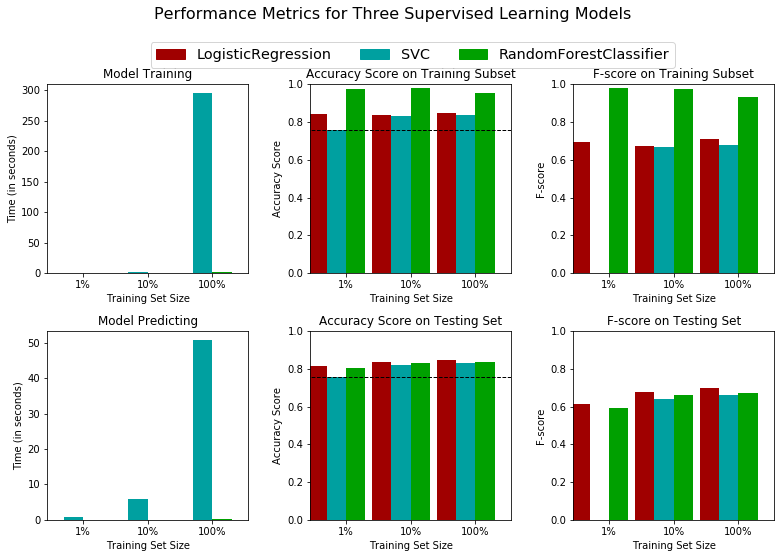

In [10]:
# TODO: Import the three supervised learning models from sklearn
#from sklearn.naive_bayes import GaussianNB
#from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression #, SGDClassifier
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier#, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.svm import SVC

# TODO: Initialize the three models
clf_A = SVC(random_state=0)
clf_B = LogisticRegression(random_state=0)
clf_C = RandomForestClassifier(random_state=0)

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_1 = int(round(0.01*len(y_train)))
samples_10 = int(round(0.10*len(y_train)))
samples_100 = int(1.0*len(y_train))

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Question 3 - Choosing the Best Model
*Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000.*  
**Hint:** Your answer should include discussion of the metrics, prediction/training time, and the algorithm's suitability for the data.

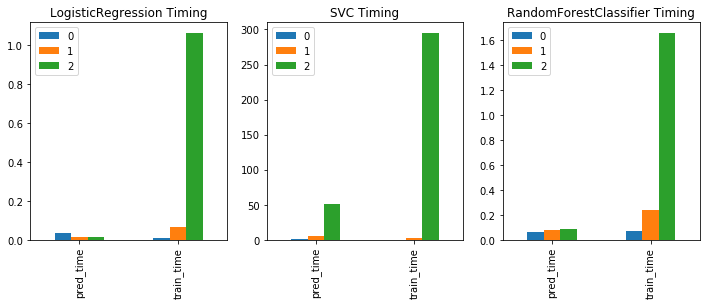

In [11]:
# First, let's plot the timing statistic to help answer the question. 
# The timing plots provided above are not very convenient as SVC blows up the axes
import matplotlib.pyplot as plt
stats = {}
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,4))
axes = [ax1, ax2, ax3]
for i, key in enumerate(results.keys()):
    stats[key] = pd.DataFrame(results[key])
    pd.DataFrame(results[key]).iloc[4:,:].plot(kind="bar", title= key+" Timing"
                                               , ax=axes[i])

**Answer: **

I looked at three models: Support Vector Machines, Logistic Regresssion and Random Forest. To decide which model is the most suitable out of these three, I can look at a few factors:

**1. Model Performance Metrics:** While the Logistic Regression perfoms dismally against the Random Forest in terms of both accuracy and F-score on the training set, it nevertheless shines when it comes to the testing set! It beats both the SVC and the Random Forest at bothe test set accuracy and F-score, making it a good contender to solving this problem since the test set is our best guess at how it will perform in the wild. It should be noted that had there been a tie on the test set accuracy, Logistic would still be the best performing considering that in this case, our F-score which properly emphasizes precision, is the best indicator for how a model will do at predicting whether or not someone earns morethan 50K.  

**2. Prediction/Training Time:** The Support Vector Machine takes longer than all the other methods, taking almost 300 seonds to train and 50 sec to predict on the data. The Random Forest takes a reasonable 1.5 seconds to train and 0.09 seconds to predict. However, Logistic Regression has the best time, taking just under 1 second to train and 0.01 seconds to predict.

**3. Suitability for the data:** While both Random Forest and SVC would be able to handle the high number of features in the data, my opinion is that Logistic Regression is most suitable for this data because after the application of L2 regularization, it too is able to handle high dimensional data. We will also have the added advantage of maximum intepretability of the model allowing us to explain the model to CharityML in a very clear way while also being able to investigate the impact of each feature on the outcome to help understand what drives the prediction of earning over 50K. 

Given it has the best F-score, the shortest training and testing times and its suitability to the data as explained above, I choose the Logistic Regression Model as the best model from among the three choices.

### Question 4 - Describing the Model in Layman's Terms
*In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical or technical jargon, such as describing equations or discussing the algorithm implementation.*

**Answer: ** 
How does the model work:

This model takes the data provided for each feature and calculates the chances that someone earns more than 50K. Even though it uses some formulas in the background, what it is essentially modeling are the odds that someone is earns more than 50K versus that they do not. If these odds are greater than 1 let's say 2, it means this individual is twice as likely to be earning more than 50K than they are to be earning less than 50K. Thus, obviously we predict that they will be earning more than 50K. if the odds are less than 1, we do the opposite. We then go down the line for each person in the data until we classify them all. This odds ratio classification is driven by a linear relationship to the features in the data for example Age; the older someone is the more likely they are to earn more than 50K and so on.

Initially, we split the data into two chunks, one smaller chunk say 20% and the remaining chunk, 80%. We use the bigger chunk to learn that linear relationship so that we know how they features relate to the odds of earning more than 50K. Because the model has not seen the other 20%, we use it to confirm and validate this relationship we just learned. The model will now be ready to predict on new data. If we have an individuals features, we just apply the relationship we learned to this person's data and we will predict the odds that they earn more than 50K, if they exceed 1 then  they are a likely donor and we should contact them. Because the model performed well on the 20% chunk it had not seen, we have more faith in it and it should also do well with new data from potential donor individuals, leading to less mistakes. 

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

In [12]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer, fbeta_score

# TODO: Initialize the classifier
clf = LogisticRegression(random_state=0)

# TODO: Create the parameters list you wish to tune
parameters = {'C': range(1,5,1), 'class_weight': [None, 'balanced', {0:0.3,1:0.7}]}

# TODO: Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score, beta=0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf, param_grid = parameters, scoring=scorer )

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print "Unoptimized model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))

Unoptimized model
------
Accuracy score on testing data: 0.8483
F-score on testing data: 0.6993

Optimized Model
------
Final accuracy score on the testing data: 0.8496
Final F-score on the testing data: 0.7017


### Question 5 - Final Model Evaluation
_What is your optimized model's accuracy and F-score on the testing data? Are these scores better or worse than the unoptimized model? How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**?_  
**Note:** Fill in the table below with your results, and then provide discussion in the **Answer** box.

#### Results:

|     Metric     | Benchmark Predictor | Unoptimized Model | Optimized Model |
| :------------: | :-----------------: | :---------------: | :-------------: | 
| Accuracy Score | 0.7562              | 0.8483            | 0.8496          |
| F-score        | 0.0                 | 0.6993            | 0.7017          |


**Answer: **

The optimized model has an accuracy of 0.8496 and an F-score of 0.7017 on the testing data which are both better than the corresponding metrics for the unoptimized model with 0.8483 and 0.6993 respectively. However, this increase is very small, but it could make a difference over time as we predict on more people and especially if the cost of mispredictions is very high which we know is a big concern for CharityML. So any improvement is a good improvement. Furthermore, the optimized model also significantly outperforms the naive predictor (from Question 1) as well which had accuracy and F-score of 0.7562 and 0.0.   

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data.  
_Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?_

In [13]:
# Let's take a look at the features available again...
features_raw.columns

Index([u'age', u'workclass', u'education_level', u'education-num',
       u'marital-status', u'occupation', u'relationship', u'race', u'sex',
       u'capital-gain', u'capital-loss', u'hours-per-week', u'native-country'],
      dtype='object')

**Answer:**

There are 13 features available in the census data i.e. Age, Workclass, Education_level', Education-num, Marital-status, Occupation, Relationship, Race, Sex, Capital-gain, Capital-loss, Hours-per-week, Native-country. Of these, I think the 5 most important for prediction are:

**1. Age** - It is common knowledge that the older you grow, the more your career progress and thus the more money and earning potential you have. Thus a 40-year old is professional is probably at mid-career level and will likely be earnining more as they have had the time and experience to hone their craft, get promoted etc. So they will usually have higher earning potential than a 23-year old recent graduate starting at an entry-level job. Thus, the older you are, the more likely you are to earn above USD50K.

**2. Education_level** - This is loosely related to age since generally the the level of education increases with age. However, after the first college degree, people take different paths. Some go on to get graduate education and would generally be expected to earn more in the job market. While having a bachelor's degree is likely predictive of higher income as well. So the higher the level of education, the more likely you are to earn above USD50K.

**3. Occupation** - Some occupations pay less than others. Handlers-cleaners likely earn less than Exec-managerial or Prof-specialty kind of workers. Thus I would expect the type of job a person does to be predictive of how much they earn. The high-prestige occupation will likely earn more than USD50K.

**4. Capital-gain** - Having capital gain probably means the person has assets and the income from those assets is profitable. Thus, they are likely to earn more than USD50K.

**5. Hours per week** - Wages are paid to compensate for the work done which is generally, though loosely in some cases,  related to the amount of time spent at work. The more time you have, the more you work, the more you get compensated. Thus, "hard-wokers" who put in a lot of hours are more likely to earn above USD50K than those who do not.  

### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, you will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

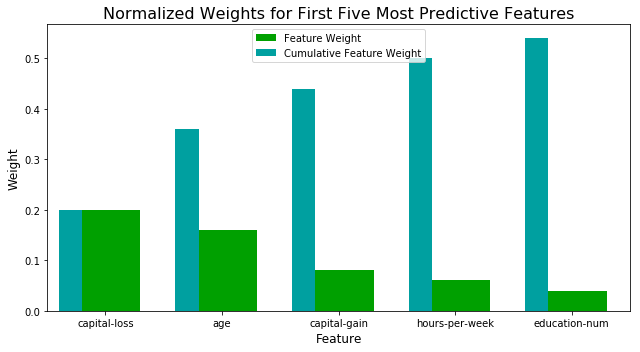

In [14]:
# TODO: Import a supervised learning model that has 'feature_importances_'
from sklearn.ensemble import AdaBoostClassifier

# TODO: Train the supervised model on the training set 
model = AdaBoostClassifier(random_state=0).fit(X_train, y_train)

# TODO: Extract the feature importances
importances = model.feature_importances_
# Plot
vs.feature_plot(importances, X_train, y_train)

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
_How do these five features compare to the five features you discussed in **Question 6**? If you were close to the same answer, how does this visualization confirm your thoughts? If you were not close, why do you think these features are more relevant?_

**Answer:**

For my initial answer, I guessed that Age, Education_level, Occupation, Capital_gain and Hours-per-week were the most important predictive features in the data. By visualizing the feature importances through AdaBoostClassifier, I have confirmed that Age, Capital gain, and Hours-per-week are indeed in the top 5 predictive features which makes sense and confirms the rationale presented above on why this might be true. However, instead of Education_level and Occupation, the features importances data suggests that Education_num (number of years of education) and Capital Loss are more important. This is not surprising to since:

**Education_num**: the number of years of education is probably correlated with the level of education and so the same reason of how it may influence the earning level is the same - the longer you study, the more you earn. Because it is a continuous variable, number of years of education captures more nuanced data not necessarily represented in the levels of education and thus would be better at classified the data.   

**Capital_loss**: having a capital loss, although it is literally negative income can actually be a signifier of wealth and assets just like capital gain. In fact, in this data, capital loss is the most important predictor of ALL the features! (followed by Age, capital gain, hours-per-week then lastly, education. Some domain knowledge on the tax code in the US might also reveal that for wealthy individuals, it may be beneficial to declare capital losses in certain years to minimize the amount of tax owing, thus maximizing their overall income and wealth. Individuals with enough assets and savvy to worry about capital losses are generally high earners. So this makes sense as a predictive indicator. Although it probably factors into the model in a similar manner to capital gains, it is also quite distinct from capital gain because in a given year one individual can only either have capital gains or capital losses and not both, at least from the data we have. In this way, the two captial gains and capital losses work in a complementary way as features, capturing individuals the other cannot capture. See confirmation of this in the empty dataframe below.

So the results are not too surprising as they are mostly consistent with my initial thoughts before analyzing feature importances. A few things to point out though is that education and hours-per-week are less important than capital gain, capital loss and age which suggests that although they are important, they only go so far and for earning more than USD50K, you need more assets, financial savvy and experience(age).  

In [15]:
# We can see below an empty data frame when we query for individuals with 
# both capital gains and capital losses in the same year!
features[(features['capital-loss']!=0) & (features['capital-gain']!=0)]

,age,education-num,capital-gain,capital-loss,hours-per-week,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia


### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [16]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
start = time()
clf = (clone(best_clf)).fit(X_train_reduced, y_train)
end = time()

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print "Final Model trained on full data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))
print "\nFinal Model trained on reduced data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5))

Final Model trained on full data
------
Accuracy on testing data: 0.8496
F-score on testing data: 0.7017

Final Model trained on reduced data
------
Accuracy on testing data: 0.8091
F-score on testing data: 0.5993


### Question 8 - Effects of Feature Selection
*How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?*  
*If training time was a factor, would you consider using the reduced data as your training set?*

In [17]:
#I have inserted some code to calculate trianing time:
t1_train = stats['LogisticRegression'].loc['train_time', 2]
t2_train = end - start
print "Training with ALL features takes : {:.4f} seconds".format(t1_train)
print "Training with 5 most important features takes : {:.4f} seconds".format(t2_train)

Training with ALL features takes : 1.0630 seconds
Training with 5 most important features takes : 0.1990 seconds


**Answer:**

**Performance** - The model training on the reduced data using only five features performs noticeably worse on both accuracy (0.8091 vs. 0.8496) and significanlty worse on F-score (0.5993 vs 0.7017)than the full model using all the features. This is not good since the F-score is the most important metric in our problem; we need to be able to identify people who earn more than 50K with high precision (the F-score is configured to put more weight on precision for this particular problem). Thus, I would not reduce the features to this particular model.  

** Training time ** - as calculated above, the model with less features takes just about the same amount of time both to test and train as the original ,full-feature model, thus I would not consider using the reduced model if training time was a factor because the both take about the same amount of time to train. Regardless,for this problem, the orders of magnitude of the time are still very small. Surely, Charity ML is willling to wait a few more seconds to get a more precise model. Infact the only time they should worry about is the time the postal service will take to deliver their letter.  

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.